ROC panel performance plot created


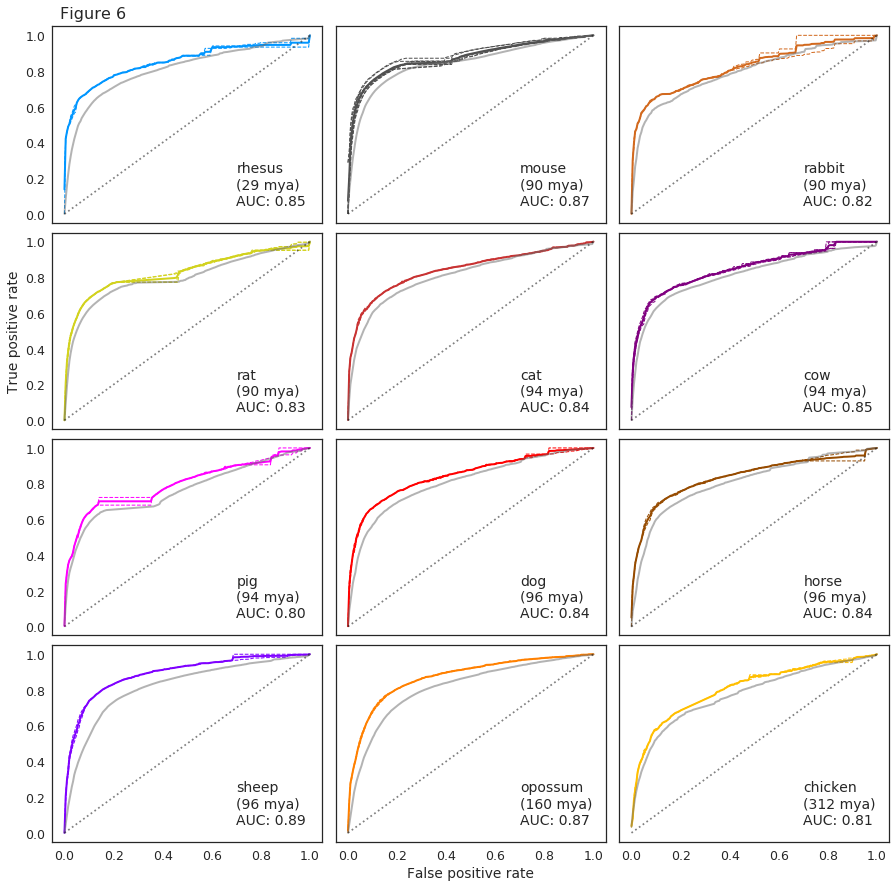

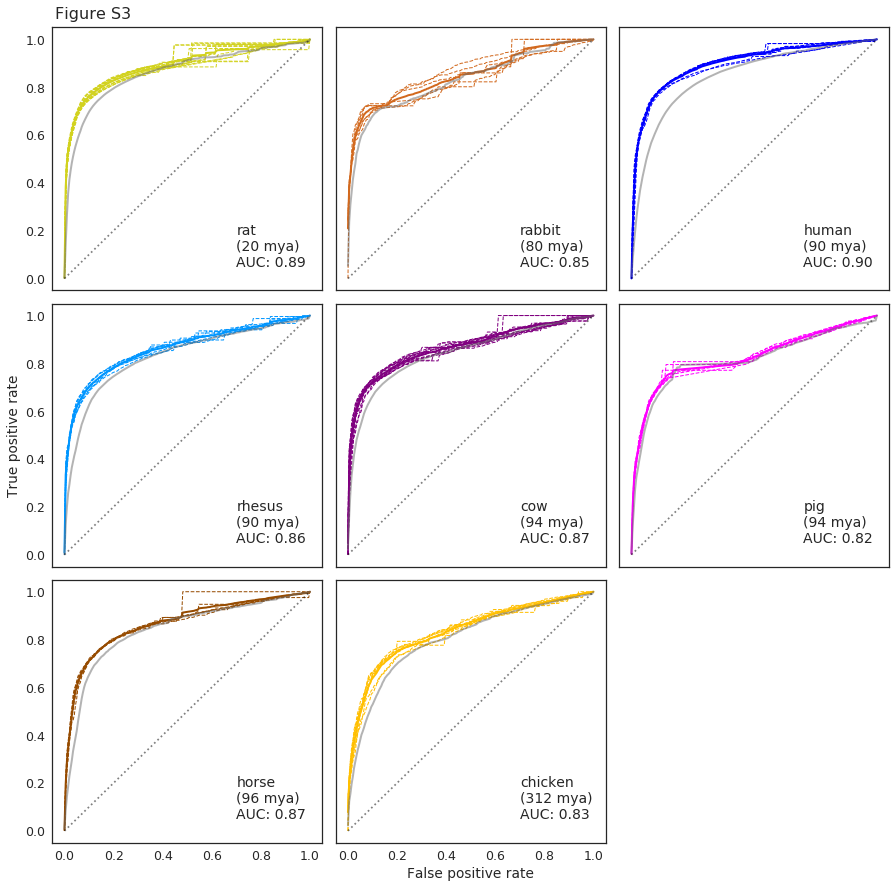

In [2]:
%matplotlib inline

import os as os
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle
from sklearn.metrics import auc, roc_auc_score, \
    average_precision_score, precision_recall_curve, roc_curve

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import numpy as np
import numpy.random as rng
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

from sklearn.metrics import precision_recall_fscore_support as pfm

date = '20180415'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_perf_comp = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_status():
    cache_file = os.path.join(cache_dir, '{}_plot_perfcomp_roc.h5'.format(date))
    model_type = 'can'
    comparison = 'pos'
    control = 'ctl'

    if os.path.isfile(cache_file):
        perf_scores, species_pairs = cache_data(cache_file, None, None)                
    else:
        collect_scores, fprs = collect_roc_curves(stat_file, model_type, comparison, control)
        perf_scores, species_pairs = cache_data(cache_file, collect_scores, fprs)
        
    species_info, lca_dist = read_references(species_file, lca_times_file)
    fig_keys = {'human': '6', 'mouse': 'S3'}
    for ref_spec in ['human', 'mouse']:
        spec_order = sorted([(p, d) for p, d in lca_dist.items() if p[0] == ref_spec and p in species_pairs],
                            key=lambda t: (t[1], t[0][1]))
        
        fig_key = fig_keys[ref_spec]
        fig, exart = plot_species_comp(perf_scores, spec_order, species_info, 'Figure ' + fig_key)
        if save_figures:
            if ref_spec == 'human':
                subfolder = 'main'
            else:
                subfolder = 'supp'
            outname = 'fig_{}_{}_roc-split'.format(fig_key, ref_spec)
            
            outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            
            outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            
            outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    return True


def cache_data(cache_file, perfs, fprs):
    
    if os.path.isfile(cache_file):
        perf_scores = {}
        species_pairs = set()
        with pd.HDFStore(cache_file, 'r') as hdf:
            for k in hdf.keys():
                if k.startswith('/control_auc') or k.startswith('/fpr'):
                    continue
                _, ref, trg, comp, data = k.split('/')
                species_pairs.add((ref, trg))
                dataset = hdf[k]
                perf_scores[(ref, trg, comp, data)] = dataset
            perf_scores['fpr'] = hdf['fpr']
        return perf_scores, species_pairs
    else:
        with pd.HDFStore(cache_file, 'w') as hdf:
            for (ref, trg, comp, data), obj in perfs.items():
                if data == 'auc':
                    hdf.put(os.path.join(ref, trg, comp, data), pd.Series(obj), format='fixed')
                elif data == 'tpr':
                    df = pd.DataFrame(obj, index=np.arange(len(obj)),
                                      columns=np.arange(obj[0].size))
                    hdf.put(os.path.join(ref, trg, comp, data), df, format='fixed')
                else:
                    raise ValueError('Unexpected data type: {}'.format(data))
            hdf.put('/fpr', pd.Series(fprs), format='fixed')
            hdf.flush()
        return cache_data(cache_file, None, None)



def plot_species_comp(perf_data, spec_order, spec_info, title):
    """
    """
    num_cols = 3
    num_rows = int(np.ceil(len(spec_order) / 3))
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 15),
                           sharex=True, sharey=True)
    extra_artists = []
    
    data_idx = 0
    x_vals_fpr = perf_data['fpr']
    for row in range(num_rows):
        for col in range(num_cols):
            if data_idx >= len(spec_order):
                this_axis = ax[row, col]
                fig.delaxes(this_axis)
                break
            this_data = spec_order[data_idx]
            qry = this_data[0][1]
            split = this_data[1]
            this_axis = ax[row, col]
            this_axis.set_xlim(-0.05, 1.05)
            this_axis.set_ylim(-0.05, 1.05)
            data_idx += 1
            # prepare data for curves
            model_tpr = perf_data[(this_data[0][0], this_data[0][1], 'pos', 'tpr')]
            model_mean_tpr = model_tpr.mean(axis=0)
            model_mean_auc = auc(x_vals_fpr, model_mean_tpr, reorder=True).round(2)
 
            control_tpr = perf_data[(this_data[0][0], this_data[0][1], 'ctl', 'tpr')]
            control_mean_tpr = control_tpr.mean(axis=0)
            control_mean_auc = auc(x_vals_fpr, control_mean_tpr, reorder=True).round(2)
    
            rgb = spec_info[this_data[0][1]]['color_rgb'].split('-')
            rgb = tuple(map(lambda x: int(x) / 255, rgb))
            for row_idx in range(model_tpr.shape[0]):
                y_vals_tpr = model_tpr.iloc[row_idx, :].values
                this_axis.plot(x_vals_fpr, y_vals_tpr, color=rgb, ls='dashed', lw=1)
            # plot mean/control curves
            this_axis.plot(x_vals_fpr, model_mean_tpr, color=rgb, ls='solid', lw=2)
            this_axis.plot(x_vals_fpr, control_mean_tpr, color='dimgrey', ls='solid', lw=2, alpha=0.5)
            this_axis.plot((0, 1), (0, 1), ls='dotted', c='black', alpha=0.5)
            # annotate axis
            this_axis.text(0.7, 0.05, '{}\n({} mya)\nAUC: {:.2f}'.format(qry, split, model_mean_auc),
                           fontsize=14)
                        
    if num_rows == 3:
        xlab_axis = ax[2, 1]
        xlab_axis.set_xlabel('False positive rate')
    else:
        xlab_axis = ax[3, 1]
        xlab_axis.set_xlabel('False positive rate')
        
    ylab_axis = ax[1, 0]
    ylab_axis.set_ylabel('True positive rate')
    
    title_axis = ax[0, 0]
    tt = title_axis.set_title(title, fontsize=16)
    tt.set_position([0.15, 1.01])
       
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
            
#     ax.set_xticks(x_vals)
#     ax.set_xticklabels(x_labels, fontsize=14, rotation=30)
        
#     handles, labels = ax.get_legend_handles_labels()
#     fig_legend = ax.legend(loc=1, fontsize=14)
        
    
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    return fig, extra_artists


def read_references(species, lca):
    """
    """
    lca_dist = dict()
    with open(lca_times_file, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            if r['timetree-org'] in ['human', 'mouse']:
                src = r['timetree-org']
                for k, v in r.items():
                    if k.startswith('time'):
                        continue
                    lca_dist[(src, k)] = int(v)
            else:
                break
    
    spec_ann = dict()
    with open(species, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            spec_ann[r['common_name']] = r

    return spec_ann, lca_dist
  

def collect_roc_curves(model_file, model_type, test_comp, control_comp):
    print('collecting')
    # interpolation points to
    # merge all ROC curves
    t_interp = np.linspace(0, 1, num=200, endpoint=True).round(3)
    collect_perf = col.defaultdict(list)
    with pd.HDFStore(model_file, 'r') as model_hdf:
        all_keys = list(model_hdf.keys())
        filter_1 = '/{}/{}'.format(control_comp, model_type)
        filter_2 = '/{}/{}'.format(test_comp, model_type)
        model_keys = sorted([k for k in all_keys if (k.startswith(filter_1) or k.startswith(filter_2))
                             and k.endswith('/roc')])
        for mk in model_keys:
            # after update, add check here for perm test scores
            components = mk.split('/')
            _, comp, featset, ref, trg, model, data, _ = components
            
            roc_data = model_hdf[mk]
            perf_data = model_hdf[mk.replace('/roc', '/perf')]
            
            auc = perf_data.loc['perf_wg', 'auc_roc']
            x_fpr = roc_data.loc['fpr', :].values
            y_tpr = roc_data.loc['tpr', :].values
            
            new_y_tpr = np.interp(t_interp, x_fpr, y_tpr)
                        
            collect_perf[(ref, trg, comp, 'tpr')].append(new_y_tpr)
            collect_perf[(ref, trg, comp, 'auc')].append(auc)
            
    return collect_perf, t_interp


if run_exec_perf_comp:
    execd = exec_status()
    print('ROC panel performance plot created')   
